In [30]:
import pymc as pm
from scipy.stats import poisson
from itertools import product
import pandas as pd
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from scipy.stats import poisson
import sqlite3

conn = sqlite3.connect(r'C:\Users\Owner\dev\algobetting\infra\data\db\fotmob.db')

league = input("League (Premer_League): ")
season = input("Season (2024-2025): ")

match_df = pd.read_sql_query(f"""
                        SELECT 
                            match_id,
                            match_date,
                            league_id,
                            season,
                            home.team_name as home_team,
                            home_goals,
                            away.team_name as away_team,
                            away_goals
                        FROM fotmob_match_data fmd
                            JOIN fotmob_team_id_mapping home ON home.team_id = fmd.home_team
                            JOIN fotmob_team_id_mapping away ON away.team_id = fmd.away_team
                        WHERE
                            league_id = '{league}'
                            AND season = '{season}'
                       """, conn)



match_df["days_ago"] = (pd.to_datetime(match_df["match_date"]).max() - pd.to_datetime(match_df["match_date"])).dt.days
match_df["match_date"] = pd.to_datetime(match_df["match_date"])



match_df

,match_id,match_date,league_id,season,home_team,home_goals,away_team,away_goals,days_ago
0,4193450,2023-08-11 19:00:00+00:00,Premier_League,2023-2024,Burnley,0,Man City,3,281
1,4193451,2023-08-12 12:00:00+00:00,Premier_League,2023-2024,Arsenal,2,Nottm Forest,1,281
2,4193452,2023-08-12 14:00:00+00:00,Premier_League,2023-2024,Bournemouth,1,West Ham,1,281
3,4193454,2023-08-12 14:00:00+00:00,Premier_League,2023-2024,Everton,0,Fulham,1,281
4,4193455,2023-08-12 14:00:00+00:00,Premier_League,2023-2024,Sheff Utd,0,Crystal Palace,1,281
...,...,...,...,...,...,...,...,...,...
337,4193905,2024-05-19 15:00:00+00:00,Premier_League,2023-2024,Chelsea,2,Bournemouth,1,0
338,4193906,2024-05-19 15:00:00+00:00,Premier_League,2023-2024,Crystal Palace,5,Aston Villa,0,0
339,4193907,2024-05-19 15:00:00+00:00,Premier_League,2023-2024,Liverpool,2,Wolves,0,0
340,4193909,2024-05-19 15:00:00+00:00,Premier_League,2023-2024,Man City,3,West Ham,1,0


In [31]:
shot_df = pd.read_sql_query(f"""
                        SELECT 
                            match_id,
                            match_date,
                            league_id,
                            season,
                            team.team_name as team,
                            side,
                            xg,
                            psxg
                        FROM fotmob_shot_data fsd
                            JOIN fotmob_team_id_mapping team ON team.team_id = fsd.team_id
                        WHERE
                            league_id = '{league}'
                            AND season = '{season}'
                       """, conn)

shot_df["days_ago"] = (pd.to_datetime(shot_df["match_date"]).max() - pd.to_datetime(shot_df["match_date"])).dt.days
shot_df["match_date"] = pd.to_datetime(shot_df["match_date"])

shot_df

,match_id,match_date,league_id,season,team,side,xg,psxg,days_ago
0,4193450,2023-08-11 19:00:00+00:00,Premier_League,2023-2024,Man City,away,0.166599,0.6196,281
1,4193450,2023-08-11 19:00:00+00:00,Premier_League,2023-2024,Man City,away,0.021549,NaN,281
2,4193450,2023-08-11 19:00:00+00:00,Premier_League,2023-2024,Man City,away,0.210887,NaN,281
3,4193450,2023-08-11 19:00:00+00:00,Premier_League,2023-2024,Burnley,home,0.077766,NaN,281
4,4193450,2023-08-11 19:00:00+00:00,Premier_League,2023-2024,Burnley,home,0.031805,0.0198,281
...,...,...,...,...,...,...,...,...,...
10097,4421797,2024-03-13 19:30:00+00:00,Premier_League,2023-2024,Bournemouth,home,0.072372,0.1087,66
10098,4421797,2024-03-13 19:30:00+00:00,Premier_League,2023-2024,Bournemouth,home,0.020979,NaN,66
10099,4421797,2024-03-13 19:30:00+00:00,Premier_League,2023-2024,Bournemouth,home,0.206112,0.7773,66
10100,4421797,2024-03-13 19:30:00+00:00,Premier_League,2023-2024,Bournemouth,home,0.084752,NaN,66


In [32]:
red_df = pd.read_sql_query(f"""
                        SELECT 
                            match_id,
                            match_date,
                            league_id,
                            season,
                            team.team_name as team,
                            side,
                            min,
                            card_type
                        FROM fotmob_red_card_data frcd
                            JOIN fotmob_team_id_mapping team ON team.team_id = frcd.team_id
                                                WHERE
                            league_id = '{league}'
                            AND season = '{season}'
                       """, conn)

red_df["days_ago"] = (pd.to_datetime(red_df["match_date"]).max() - pd.to_datetime(red_df["match_date"])).dt.days
red_df["match_date"] = pd.to_datetime(red_df["match_date"])

red_df

,match_id,match_date,league_id,season,team,side,min,card_type,days_ago
0,4193450,2023-08-11 19:00:00+00:00,Premier_League,2023-2024,Burnley,home,90,Red Card,281
1,4193471,2023-08-21 19:00:00+00:00,Premier_League,2023-2024,Arsenal,away,67,Red Card,271
2,4193472,2023-08-19 14:00:00+00:00,Premier_League,2023-2024,Fulham,home,64,Red Card,274
3,4193473,2023-08-19 14:00:00+00:00,Premier_League,2023-2024,Liverpool,home,58,Red Card,274
4,4193478,2023-08-20 15:30:00+00:00,Premier_League,2023-2024,West Ham,home,67,Red Card,272
5,4193479,2023-08-19 14:00:00+00:00,Premier_League,2023-2024,Wolves,home,90,Red Card,274
6,4193481,2023-08-26 14:00:00+00:00,Premier_League,2023-2024,Fulham,away,83,Red Card,267
7,4193487,2023-08-26 14:00:00+00:00,Premier_League,2023-2024,Nottm Forest,away,67,Red Card,267
8,4193488,2023-08-27 15:30:00+00:00,Premier_League,2023-2024,Liverpool,away,28,Red Card,265
9,4193506,2023-09-18 18:45:00+00:00,Premier_League,2023-2024,Burnley,away,90,Red Card,243


In [33]:
def poisson_binomial_pmf(k, p_values):
    """
    Calculate PMF of Poisson-Binomial distribution for k successes
    given array of success probabilities p_values
    
    Uses dynamic programming approach for efficiency
    """
    n = len(p_values)
    if k > n or k < 0:
        return 0.0
    
    # Dynamic programming table
    # dp[i][j] = probability of exactly j successes using first i trials
    dp = np.zeros((n + 1, k + 1))
    dp[0][0] = 1.0  # Base case: 0 trials, 0 successes
    
    for i in range(1, n + 1):
        p = p_values[i - 1]
        dp[i][0] = dp[i - 1][0] * (1 - p)  # 0 successes
        
        for j in range(1, min(i, k) + 1):
            # j successes = (j successes from first i-1, no success on trial i) +
            #               (j-1 successes from first i-1, success on trial i)
            dp[i][j] = dp[i - 1][j] * (1 - p) + dp[i - 1][j - 1] * p
    
    return dp[n][k]

def simulate_shots_poisson_binomial(xg_values, max_goals=None):
    """
    Simulate goal probabilities using Poisson-Binomial distribution
    
    Args:
        xg_values: array of xG values for individual shots
        max_goals: maximum number of goals to consider (default: number of shots)
    
    Returns:
        dict with goals as keys and probabilities as values
    """
    if len(xg_values) == 0:
        return {0: 1.0}
    
    if max_goals is None:
        max_goals = len(xg_values)
    
    goal_probs = {}
    for goals in range(max_goals + 1):
        prob = poisson_binomial_pmf(goals, xg_values)
        if prob > 1e-10:  # Only keep non-negligible probabilities
            goal_probs[goals] = prob
    
    return goal_probs

def simulate_game_poisson_binomial(home_xg_shots, away_xg_shots, max_goals=9):
    """
    Simulate a game using Poisson-Binomial distribution for each team
    
    Args:
        home_xg_shots: array of xG values for home team shots
        away_xg_shots: array of xG values for away team shots
        max_goals: maximum goals to consider for each team
    
    Returns:
        list of dicts with home_goals, away_goals, and probability
    """
    home_probs = simulate_shots_poisson_binomial(home_xg_shots, max_goals)
    away_probs = simulate_shots_poisson_binomial(away_xg_shots, max_goals)
    
    game_probs = []
    for (h_goals, h_prob), (a_goals, a_prob) in product(home_probs.items(), away_probs.items()):
        combined_prob = h_prob * a_prob
        if combined_prob > 1e-6:  # Filter very small probabilities
            game_probs.append({
                'home_goals': h_goals,
                'away_goals': a_goals,
                'probability': combined_prob
            })
    
    return game_probs

def create_weighted_scoreline_data_poisson_binomial(
    df, 
    shot_data, 
    red_cards,  # Assuming this is a DataFrame with columns: match_url, minute, side
    max_goals=9, 
    min_prob_threshold=0.001,
    decay_rate=0.001,
    goals_weight=0.2,
    xg_weight=0.5,
    psxg_weight=0.3
):
    """
    Create expanded dataset with all possible scorelines using both Poisson-Binomial 
    and Poisson distributions for comparison
    """
    expanded_data = []
    
    for idx, row in df.iterrows():
        match_id = row['match_id']
        
        # Get shot data for this match
        match_shots = shot_data[shot_data["match_id"] == match_id]
        
        if match_shots.empty:
            print(f"Warning: No shot data found for match_id {match_id}")
            continue
            
        home_xg_shots = match_shots[match_shots['side'] == 'home']['xg'].values
        away_xg_shots = match_shots[match_shots['side'] == 'away']['xg'].values

        home_psxg_shots = match_shots[match_shots['side'] == 'home']['psxg'].values
        away_psxg_shots = match_shots[match_shots['side'] == 'away']['psxg'].values

        # Get red cards for THIS specific match
        match_red_cards = red_cards[red_cards['match_id'] == match_id]
        
        # Calculate red card penalty for this match
        if match_red_cards.empty:
            red_card_penalty = 1.0  # No penalty if no red cards
        else:
            # Get the earliest red card minute for this match
            earliest_red_minute = match_red_cards['min'].min()
            
            # Apply penalty based on when the red card occurred
            if earliest_red_minute > 80:
                red_card_penalty = 0.7
            elif earliest_red_minute > 70:
                red_card_penalty = 0.6
            elif earliest_red_minute > 60:
                red_card_penalty = 0.5
            elif earliest_red_minute > 45:
                red_card_penalty = 0.4
            elif earliest_red_minute > 30:
                red_card_penalty = 0.25
            elif earliest_red_minute > 15:
                red_card_penalty = 0.1
            else:  # Red card in first 20 minutes
                red_card_penalty = 0.025
        
        # Rest of your existing code...
        home_total_xg = home_xg_shots.sum()
        away_total_xg = away_xg_shots.sum()
        
        # Generate scorelines with Poisson-Binomial (individual shots)
        xg_game_probs_pb = simulate_game_poisson_binomial(home_xg_shots, away_xg_shots, max_goals)
        psxg_game_probs_pb = simulate_game_poisson_binomial(home_psxg_shots, away_psxg_shots, max_goals)
        
        # Generate scorelines with regular Poisson (total xG)
        home_total_xg_probs = {i: poisson.pmf(i, home_total_xg) for i in range(max_goals + 1)}
        away_total_xg_probs = {i: poisson.pmf(i, away_total_xg) for i in range(max_goals + 1)}
        
        # Create lookup for Poisson-Binomial probabilities
        xg_pb_prob_lookup = {(sp['home_goals'], sp['away_goals']): sp['probability'] 
                         for sp in xg_game_probs_pb}
        psxg_pb_prob_lookup = {(sp['home_goals'], sp['away_goals']): sp['probability'] 
                         for sp in psxg_game_probs_pb}
        
        # Get actual scoreline
        actual_home = int(row['home_goals'])
        actual_away = int(row['away_goals'])
        
        # Store match scorelines temporarily
        match_scorelines = []
        
        # Iterate through all possible scorelines
        for home_goals in range(max_goals + 1):
            for away_goals in range(max_goals + 1):
                
                # Get probabilities from both methods
                xg_pb_prob = xg_pb_prob_lookup.get((home_goals, away_goals), 0.0)
                psxg_pb_prob = psxg_pb_prob_lookup.get((home_goals, away_goals), 0.0)
                xg_total_poisson_prob = home_total_xg_probs[home_goals] * away_total_xg_probs[away_goals]
                
                # Skip if all probabilities are negligible
                if xg_pb_prob < 1e-10 and xg_total_poisson_prob < 1e-10 and psxg_pb_prob < 1e-10:
                    continue
                
                # Check if this is the actual scoreline
                is_actual = (home_goals == actual_home and away_goals == actual_away)
                
                match_scorelines.append({
                    'match_id': match_id,
                    'home_team': row['home_team'],
                    'away_team': row['away_team'],
                    'home_goals': home_goals,
                    'away_goals': away_goals,
                    'days_ago': row['days_ago'],
                    'is_actual': is_actual,
                    'xg_pb_prob_raw': xg_pb_prob,
                    'psxg_pb_prob_raw': psxg_pb_prob,
                    'xg_total_poisson_prob_raw': xg_total_poisson_prob,
                })
        
        if not match_scorelines:
            continue
            
        # Filter by minimum probability threshold BEFORE normalization
        filtered_scorelines = []
        for scoreline in match_scorelines:
            # Use a simple threshold on raw probabilities or keep actual scoreline
            if (scoreline['xg_pb_prob_raw'] >= min_prob_threshold or 
                scoreline['psxg_pb_prob_raw'] >= min_prob_threshold or 
                scoreline['xg_total_poisson_prob_raw'] >= min_prob_threshold or 
                scoreline['is_actual']):
                filtered_scorelines.append(scoreline)
        
        # NOW normalize probabilities within the filtered set
        total_xg_pb_prob = sum(s['xg_pb_prob_raw'] for s in filtered_scorelines)
        total_psxg_pb_prob = sum(s['psxg_pb_prob_raw'] for s in filtered_scorelines)
        total_xg_total_poisson_prob = sum(s['xg_total_poisson_prob_raw'] for s in filtered_scorelines)
        
        for scoreline in filtered_scorelines:
            scoreline['poisson_binomial_xg_prob'] = scoreline['xg_pb_prob_raw'] / total_xg_pb_prob if total_xg_pb_prob > 0 else 0
            scoreline['poisson_binomial_psxg_prob'] = scoreline['psxg_pb_prob_raw'] / total_psxg_pb_prob if total_psxg_pb_prob > 0 else 0
            scoreline['poisson_xg_total_prob'] = scoreline['xg_total_poisson_prob_raw'] / total_xg_total_poisson_prob if total_xg_total_poisson_prob > 0 else 0
        
        # Calculate remaining weight after actual scoreline boost
        remaining_weight = 1.0 - goals_weight
        
        # Apply weighting and store current match data
        current_match_data = []
        for scoreline in filtered_scorelines:
            normalized_pb_xg_prob = scoreline['poisson_binomial_xg_prob']
            normalized_pb_psxg_prob = scoreline["poisson_binomial_psxg_prob"]
            normalized_p_xg_total_prob = scoreline["poisson_xg_total_prob"]
            
            # Calculate weights (using goals_weight as boost for actual scorelines)
            if scoreline['is_actual']:
                # Actual scoreline gets goals_weight as boost
                final_weight = goals_weight + (remaining_weight * (
                    xg_weight * normalized_p_xg_total_prob + 
                    psxg_weight * normalized_pb_psxg_prob
                ))
            else:
                # Non-actual scorelines get weighted probability without boost
                final_weight = remaining_weight * (
                    xg_weight * normalized_p_xg_total_prob + 
                    psxg_weight * normalized_pb_psxg_prob
                )
            
            current_match_data.append({
                'match_id': scoreline['match_id'],
                'home_team': scoreline['home_team'],
                'away_team': scoreline['away_team'],
                'home_goals': scoreline['home_goals'],
                'away_goals': scoreline['away_goals'],
                'weight': final_weight,
                'days_ago': scoreline['days_ago'],
                'is_actual': scoreline['is_actual'],
                'poisson_binomial_xg_prob': normalized_pb_xg_prob,
                'poisson_binomial_psxg_prob': normalized_pb_psxg_prob,
                'poisson_xg_total_prob': normalized_p_xg_total_prob
            })
        
        # Normalize weights so they sum to 1 for this match (BEFORE time decay)
        total_weight_for_match = sum(s['weight'] for s in current_match_data)
        if total_weight_for_match > 0:
            for s in current_match_data:
                s['weight'] = s['weight'] / total_weight_for_match
        
        # NOW apply time decay to the entire match
        time_weight = np.exp(-decay_rate * row['days_ago'])
        for s in current_match_data:
            s['weight'] = s['weight'] * time_weight * red_card_penalty

     
        # Add to expanded_data
        expanded_data.extend(current_match_data)
    
    return pd.DataFrame(expanded_data)

# Example usage:

# With shot-level data:
df = create_weighted_scoreline_data_poisson_binomial(
    match_df, 
    shot_df,
    red_df,
    max_goals=9,
    decay_rate=0.001,
    goals_weight=0.2,
    xg_weight=0.5,
    psxg_weight=0.3
)

df

,match_id,home_team,away_team,home_goals,away_goals,weight,days_ago,is_actual,poisson_binomial_xg_prob,poisson_binomial_psxg_prob,poisson_xg_total_prob
0,4193450,Burnley,Man City,0,0,0.032077,281,False,0.066098,0.0,0.091038
1,4193450,Burnley,Man City,0,1,0.066605,281,False,0.183274,0.0,0.189031
2,4193450,Burnley,Man City,0,2,0.069149,281,False,0.219859,0.0,0.196253
3,4193450,Burnley,Man City,0,3,0.224034,281,True,0.151773,0.0,0.135834
4,4193450,Burnley,Man City,0,4,0.024844,281,False,0.067531,0.0,0.070511
...,...,...,...,...,...,...,...,...,...,...,...
10498,4193910,Sheff Utd,Tottenham,4,1,0.001318,0,False,0.000226,0.0,0.001978
10499,4193910,Sheff Utd,Tottenham,4,2,0.002081,0,False,0.000694,0.0,0.003122
10500,4193910,Sheff Utd,Tottenham,4,3,0.002191,0,False,0.000947,0.0,0.003286
10501,4193910,Sheff Utd,Tottenham,4,4,0.001729,0,False,0.000699,0.0,0.002594


In [34]:
((match_df["home_goals"].sum() + match_df["away_goals"].sum()) / 380) / 2

1.4592105263157895

In [35]:
teams = df["home_team"].unique()
n_teams = len(teams)
home_idx = pd.Categorical(df["home_team"], categories=teams).codes
away_idx = pd.Categorical(df["away_team"], categories=teams).codes


home_goals_obs = df["home_goals"]
away_goals_obs = df["away_goals"]

In [36]:
import arviz as az
import pickle
import os
from pathlib import Path

def save_season_trace(trace, season_year, league, model_version="v1"):
    """Save trace for future use"""
    save_dir = Path(f"model_traces/{model_version}")
    save_dir.mkdir(parents=True, exist_ok=True)
    
    # ArviZ NetCDF format (recommended - preserves all metadata)
    trace_path = save_dir / f"trace_{league}_{season_year}.nc"
    trace.to_netcdf(trace_path)
    
    # Also save a summary for quick reference
    summary_path = save_dir / f"summary_{season_year}.csv"
    az.summary(trace).to_csv(summary_path)
    
    print(f"Saved trace for {season_year} to {trace_path}")
    return trace_path


def load_previous_traces(current_season, league, model_version="v1", n_previous=3):
    """Load traces from previous seasons"""
    save_dir = Path(f"model_traces/{model_version}")
    previous_traces = []
    
    # Load traces from most recent seasons
    for year in range(current_season - n_previous, current_season):
        trace_path = save_dir / f"trace_{league}_{year}.nc"
        if trace_path.exists():
            try:
                trace = az.from_netcdf(trace_path)
                previous_traces.append(trace)
                print(f"Loaded trace for {year}")
            except Exception as e:
                print(f"Failed to load trace for {year}: {e}")
    
    return previous_traces

In [37]:
with pm.Model() as model:
    att_str_raw = pm.Normal("att_str_raw", mu=0, sigma=1, shape=n_teams)
    def_str_raw = pm.Normal("def_str_raw", mu=0, sigma=1, shape=n_teams)
     
    att_str = pm.Deterministic("att_str", att_str_raw - pm.math.mean(att_str_raw))
    def_str = pm.Deterministic("def_str", def_str_raw - pm.math.mean(def_str_raw))
    
    home_adv = pm.Gamma("home_adv", alpha=4, beta=4/0.128)

    baseline = pm.Normal("baseline", mu=np.log(1.467), sigma=0.1)

    home_goals_mu = pm.math.exp(baseline + att_str[home_idx] + def_str[away_idx] + home_adv)
    away_goals_mu = pm.math.exp(baseline + att_str[away_idx] + def_str[home_idx])

    weights = pm.ConstantData("weights", df["weight"].values)
    
    home_logp = pm.logp(pm.Poisson.dist(mu=home_goals_mu), home_goals_obs)
    away_logp = pm.logp(pm.Poisson.dist(mu=away_goals_mu), away_goals_obs)

    pm.Potential("weighted_home_goals", pm.math.sum(weights * home_logp))
    pm.Potential("weighted_away_goals", pm.math.sum(weights * away_logp))

    trace = pm.sample(5000, tune=2500, cores=4, nuts_sampler='blackjax', return_inferencedata=True)

save_season_trace(trace, league='Premier_League', season_year=season[:4])

c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\sampling\jax.py:368: UserWarning: BlackJax currently only display progress bar correctly under `chain_method == 'vectorized'`. Setting `progressbar=False`.
  warnings.warn(


Saved trace for 2023 to model_traces\v1\trace_Premier_League_2023.nc


WindowsPath('model_traces/v1/trace_Premier_League_2023.nc')

In [38]:
previous_traces = load_previous_traces(2026, 'Premier_League', 'v1', n_previous=1)

previous_traces

Loaded trace for 2025


[Inference data with groups:
 	> posterior
 	> sample_stats
 	> constant_data]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
att_str_raw[0],-0.384,0.292,-0.920,0.180,0.008,0.006,1255.0,2564.0,1.0
att_str_raw[1],0.361,0.259,-0.121,0.850,0.008,0.006,980.0,1813.0,1.0
att_str_raw[2],-0.074,0.275,-0.582,0.443,0.008,0.006,1075.0,2057.0,1.0
att_str_raw[3],-0.165,0.276,-0.694,0.345,0.008,0.006,1125.0,2195.0,1.0
att_str_raw[4],-0.462,0.294,-1.022,0.085,0.008,0.006,1257.0,2625.0,1.0
...,...,...,...,...,...,...,...,...,...
def_str[14],-0.024,0.146,-0.303,0.245,0.001,0.001,28901.0,14539.0,1.0
def_str[15],0.127,0.136,-0.135,0.376,0.001,0.001,34161.0,14149.0,1.0
def_str[16],0.253,0.124,0.024,0.490,0.001,0.001,35707.0,13946.0,1.0
def_str[17],0.096,0.135,-0.158,0.350,0.001,0.001,32339.0,15048.0,1.0


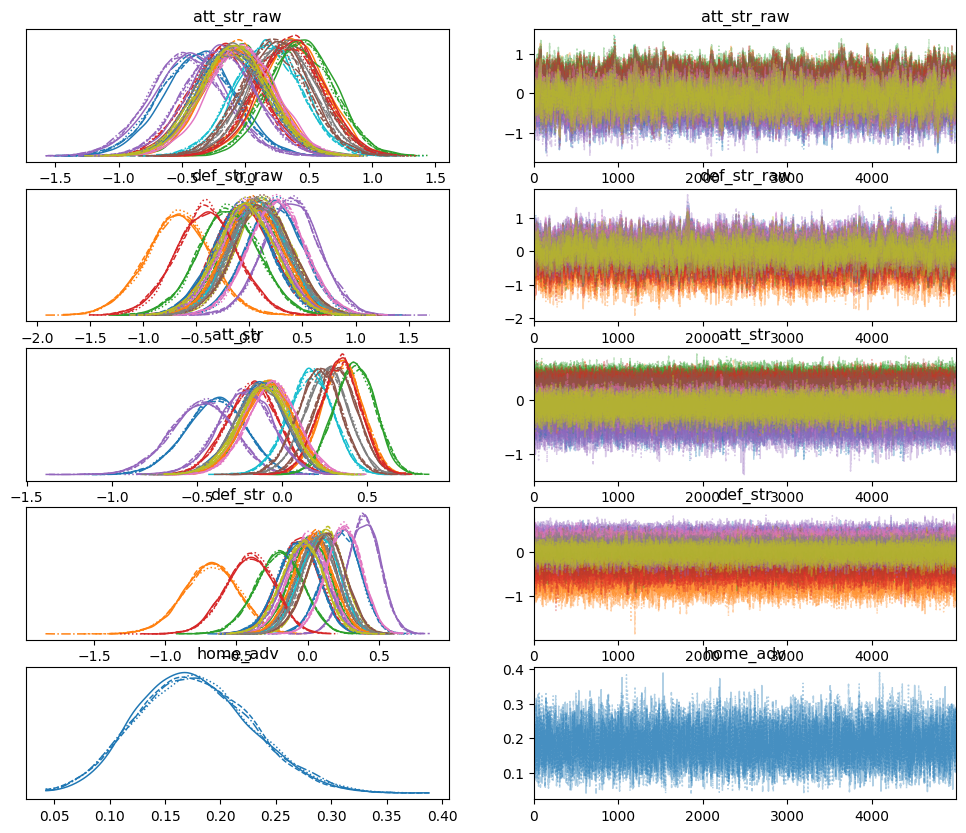

In [39]:
# Summary statistics for all parameters
az.summary(trace)

# Trace plots for all parameters
az.plot_trace(trace, var_names=[
    "att_str_raw", 
    "def_str_raw", 
    "att_str",     
    "def_str",            
    "home_adv"
])


az.summary(trace)

In [40]:

# Get team rankings
att_summary = az.summary(trace, var_names=["att_str"])
att_summary.index = teams
print("Attack Strength Rankings:")
att_summary[['mean', 'hdi_3%', 'hdi_97%']].sort_values("mean", ascending=False)



Attack Strength Rankings:


,mean,hdi_3%,hdi_97%
Liverpool,0.424,0.197,0.649
Arsenal,0.349,0.124,0.569
Man City,0.338,0.116,0.560
Newcastle,0.311,0.079,0.548
Chelsea,0.260,0.022,0.505
Tottenham,0.214,-0.027,0.455
Aston Villa,0.165,-0.090,0.403
West Ham,-0.060,-0.332,0.221
Fulham,-0.080,-0.345,0.197
Bournemouth,-0.086,-0.380,0.181


In [41]:
def_summary = az.summary(trace, var_names=["def_str"]) 
def_summary.index = teams
print("\nDefense Strength Rankings (lower is better):")
def_summary[['mean', 'hdi_3%', 'hdi_97%']].sort_values("mean", ascending=True)


Defense Strength Rankings (lower is better):


,mean,hdi_3%,hdi_97%
Arsenal,-0.682,-1.047,-0.328
Man City,-0.408,-0.730,-0.097
Liverpool,-0.200,-0.512,0.101
Crystal Palace,-0.069,-0.344,0.196
Everton,-0.065,-0.333,0.199
Brighton,-0.038,-0.313,0.222
Nottm Forest,-0.024,-0.303,0.245
Brentford,0.000,-0.257,0.266
Bournemouth,0.014,-0.258,0.274
Fulham,0.037,-0.229,0.291


In [42]:
import numpy as np

# With sum-to-zero constraints, league average is simply 0
att_league_avg = 0.0
def_league_avg = 0.0
home_adv_mean = az.summary(trace, var_names=["home_adv"])['mean'].iloc[0]
baseline_mean = az.summary(trace, var_names=["baseline"])['mean'].iloc[0]

print(home_adv_mean)


def convert_to_expected_goals_constrained(att_summary, def_summary, baseline, home_adv):
    results = []
    
    for team in teams:
        team_att = att_summary.loc[team, 'mean']
        team_def = def_summary.loc[team, 'mean']
        
        # Expected goals FOR this team vs league average opponent
        goals_for = np.exp(baseline + team_att + def_league_avg)
        
        # Expected goals AGAINST this team vs league average opponent  
        goals_against = np.exp(baseline + att_league_avg + team_def)
        
        results.append({
            'Team': team,
            'Goals_For': goals_for,
            'Goals_Against': goals_against,
            'Goal_Diff': goals_for - goals_against
        })
    
    return pd.DataFrame(results)

# Create the conversion
goals_df = convert_to_expected_goals_constrained(att_summary, def_summary, baseline_mean, home_adv_mean)

print("\nExpected Goals vs League Average Team:")
print(goals_df[['Team', 'Goals_For', 'Goals_Against', 'Goal_Diff']].sort_values('Goal_Diff', ascending=False))

print(goals_df["Goals_For"].sum())
print(goals_df["Goals_Against"].sum())

0.177

Expected Goals vs League Average Team:
              Team  Goals_For  Goals_Against  Goal_Diff
1          Arsenal   1.956193       0.697676   1.258516
13        Man City   1.934792       0.917594   1.017198
12       Liverpool   2.108549       1.129754   0.978795
5        Newcastle   1.883252       1.468145   0.415106
7          Chelsea   1.789614       1.462285   0.327329
15       Tottenham   1.709157       1.566745   0.142412
9      Aston Villa   1.627427       1.499303   0.128124
10  Crystal Palace   1.208041       1.287883  -0.079842
18        Brighton   1.232445       1.328433  -0.095988
6        Brentford   1.258600       1.379885  -0.121285
2      Bournemouth   1.266174       1.399339  -0.133165
3          Everton   1.156040       1.293045  -0.137006
11          Fulham   1.273794       1.431897  -0.158103
14    Nottm Forest   1.108491       1.347162  -0.238670
17          Wolves   1.214096       1.518921  -0.304824
8       Man United   1.244831       1.566745  -0.321913
16